In [149]:
import re
import math
from collections import Counter
from functools import reduce 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Creating Naive Bayes classifier

In [150]:
# I reused some of the code from problem set 2 to make naive Bayes classifiers for Reddit comments 
# in a given community based on their valence (positive or negative net score).

pos_comm_token_counts = Counter() #token counts for positive comments
pos_comm_count = 0 #number of positive comments
neg_comm_token_counts = Counter() #token counts for negative comments
neg_comm_count = 0 #number of negative comments

token_pattern = re.compile("\w+")

d_pos_test_set = []
d_neg_test_set = []

In [151]:
with open("the_donald_pos_comms.txt", "r")as inf:
    #create positive comment and token counts
    pfile = inf.readlines()
    testing_lim = len(pfile) - (len(pfile) * .2)
    for line in pfile: 
        if pos_comm_count >= testing_lim: #reserve 20% for testing
            d_pos_test_set.append(line)
        else: 
            pos_comm_token_counts.update(token_pattern.findall(line))
            pos_comm_count += 1
        
  
with open("the_donald_neg_comms.txt", "r")as infn:
    #create negative comment and token counts
    nfile = infn.readlines()
    testing_lim = len(nfile) - (len(nfile) * .2)
    for line in nfile:
        if neg_comm_count >= testing_lim: #reserve 20% for testing
            d_neg_test_set.append(line)
        else:
            neg_comm_token_counts.update(token_pattern.findall(line))
            neg_comm_count += 1

In [152]:
# #write test arrays to files to feed into classify()
# with open("the_donald_test_pos_comms.txt", "w") as out: 
#     for x in d_pos_test_set:
#         out.write(x)
        
# with open("the_donald_test_neg_comms.txt", "w") as out: 
#     for x in d_neg_test_set:
#         out.write(x)

In [153]:
P_pos = pos_comm_count/(pos_comm_count + neg_comm_count)
print (P_pos)

0.7783114256825076


In [154]:
positive_tokens = sum(pos_comm_token_counts.values())
negative_tokens = sum(neg_comm_token_counts.values())

In [155]:
def word_log_prob(word, counter, summ):
    if (counter[word]/summ) == 0: return 0
    else: return math.log(counter[word]/summ)

def comment_log_prob(phrase, counter, summ):
    phrase_tokens = token_pattern.findall(phrase)
    phrase_prob = reduce((lambda x, y: x+y), [word_log_prob(token, counter, summ) for token in phrase_tokens])  
    return phrase_prob


In [156]:
print ("*pos word probs*")
print(word_log_prob("Bernie", pos_comm_token_counts, positive_tokens))
print ("\n*neg word probs*")
print(word_log_prob("Bernie", neg_comm_token_counts, negative_tokens))
#maybe try slurs? tried so far: sucks, wrong, bernie, maga

*pos word probs*
-9.364334995671273

*neg word probs*
-9.682778535337379


In [157]:
both_counts = pos_comm_token_counts + neg_comm_token_counts
both_tokens = sum(both_counts.values())
vocabulary_size = len(both_counts)
print(vocabulary_size)

19212


In [158]:
def smoothed_word_log_prob(word, counter, summ):
    return math.log((counter[word] + 1)/(summ + vocabulary_size))

def smoothed_comm_log_prob(phrase, counter, summ):
    phrase_tokens = token_pattern.findall(phrase)
    phrase_prob = reduce((lambda x, y: x+y), [smoothed_word_log_prob(token, counter, summ) for token in phrase_tokens])  
    return phrase_prob

In [159]:
log_P_pos = math.log(pos_comm_count/(pos_comm_count + neg_comm_count))
log_P_neg = math.log(neg_comm_count/(pos_comm_count + neg_comm_count))

def classifier_score(comment):
    log_P_words_given_pos = smoothed_comm_log_prob(comment, pos_comm_token_counts, positive_tokens)
    log_P_words_given_neg = smoothed_comm_log_prob(comment, neg_comm_token_counts, negative_tokens)
    return (log_P_words_given_pos + log_P_pos) - (log_P_words_given_neg + log_P_neg)

In [160]:
def classify(sub):
    #Classify all sampled comments for subreddit [sub]. Return an array containing: an array of classifier scores 
    #for positive comments, an array of classifier scores for negative comments, and four arrays containing comments 
    #with positive scores greater than 20, less than -20, negative scores greater than 20, less than -20 respectively.
    p_greater20 = []
    p_lessneg20 = [] 
    with open(sub + "_pos_comms.txt", "r")as inf:
        pfile = inf.readlines()
        classified_p = np.zeros(len(pfile))
        for i, line in enumerate(pfile):
            if line.strip() == "": 
                next
            else:
                c_score = classifier_score(line)
                classified_p[i] = c_score
                if c_score > 20:
                    p_greater20.append((i, line))
                if c_score < -20:
                    p_lessneg20.append((i, line))

    n_greater20 = []
    n_lessneg20 = []
    with open(sub + "_neg_comms.txt", "r")as inf:
        nfile = inf.readlines()
        classified_n = np.zeros(len(nfile))
        for i, line in enumerate(nfile): 
            if line.strip() == "": 
                next
            else:
                c_score = classifier_score(line)
                classified_n[i] = classifier_score(line)
                if c_score > 20:
                    n_greater20.append((i, line))
                if c_score < -20:
                    n_lessneg20.append((i, line))
    return [classified_p, classified_n, p_greater20, p_lessneg20, n_greater20, n_lessneg20]

#I included the arrays with "outlier" comments in case it would be interesting to look at the content of those comments. 

## Model validation

In [161]:
#checking how the model performs on trained data
classified_donald = classify("the_donald")
classified_donald_p = classified_donald[0]
classified_donald_n = classified_donald[1]

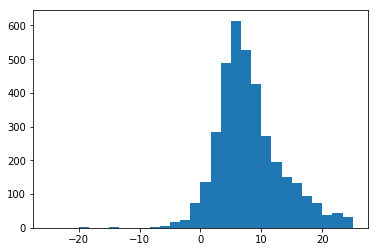

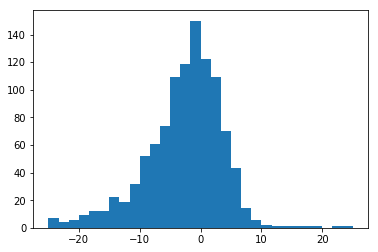

In [162]:
plt.hist(classified_donald_p, bins=30, range=[-25,25])
plt.show()
plt.hist(classified_donald_n, bins=30, range=[-25,25])
plt.show()

positive performed well, negative performed alright. 

In [163]:
#checking how model performs on test data
classified_donald_t = classify("the_donald_test")
classified_donald_p_t = classified_donald_t[0]
classified_donald_n_t = classified_donald_t[1]

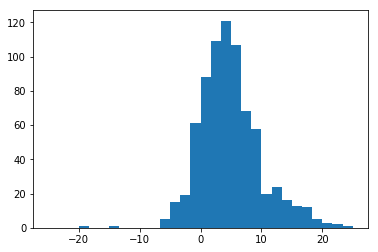

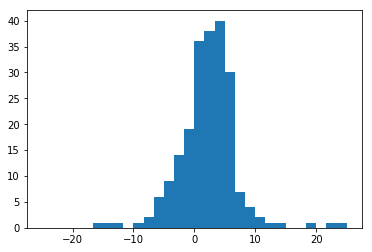

In [164]:
plt.hist(classified_donald_p_t, bins=30, range=[-25,25])
plt.show()
plt.hist(classified_donald_n_t, bins=30, range=[-25,25])
plt.show()

Similarly to the Hillary classifier, performs well on positive and not so well on negative. 

In [165]:
p_lab = [1 for x in range(len(classified_donald_p_t))]
n_lab = [-1 for x in range(len(classified_donald_n_t))]
p_lab.extend(n_lab)
true_labels_p = np.array(p_lab)
pt_lab = [1 if x >= 0 else -1 for x in classified_donald_p_t]
nt_lab = [1 if x >= 0 else -1 for x in classified_donald_n_t]
pt_lab.extend(nt_lab)
predictions = np.array(pt_lab)

Text(0.5, 1.0, 'Hillary classifier validation')

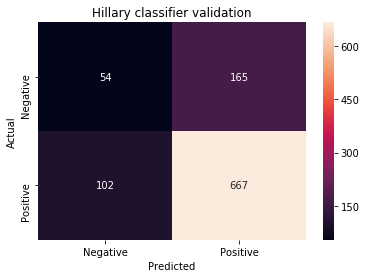

In [166]:
ticklabels = ['Negative', 'Positive']
sns.heatmap(confusion_matrix(true_labels_p, predictions), annot=True, fmt='d', xticklabels=ticklabels, yticklabels=ticklabels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Hillary classifier validation')

In [167]:
true_pos = 667
true_neg = 54
false_pos = 165
false_neg = 102
precision = true_pos/(true_pos + false_pos)
recall = true_pos/(true_pos + false_neg)
f1 = 2*((precision*recall)/(precision+recall)) # a measure of accuracy; integrating precision and recall
print("for positives")
print("precision: " + str(precision))
print("recall: " + str(recall))
print ("f1(accuracy): " + str(f1))

for positives
precision: 0.8016826923076923
recall: 0.8673602080624188
f1(accuracy): 0.8332292317301686


In [168]:
precision = true_neg/(true_neg + false_neg)
recall = true_neg/(true_neg + false_pos)
f1 = 2*((precision*recall)/(precision+recall)) # a measure of accuracy; integrating precision and recall
print("for positives")
print("precision: " + str(precision))
print("recall: " + str(recall))
print ("f1(accuracy): " + str(f1))

for positives
precision: 0.34615384615384615
recall: 0.2465753424657534
f1(accuracy): 0.288


confirming with numbers what we saw in the histograms: pretty good for positive comments (about 80% correct), dismal for negative comments (about 30% correct). These numbers are pretty similar between the Hillary and Donald classifiers as well. It may be a factor of how much smaller the negatively scored comments set (~1000) is compared with the positively scored comments (~4000).

# Classifying comments from other subreddits

In [169]:
classified_hillary = classify("hillaryclinton")
classified_hillary_p = classified_hillary[0]
classified_hillary_n = classified_hillary[1]

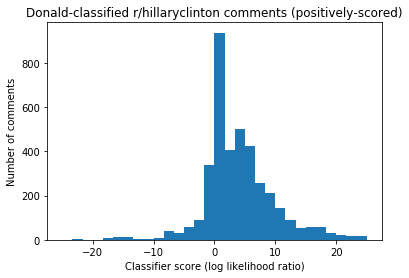

In [170]:
fig, ax=plt.subplots()
ax.set(title = "Donald-classified r/hillaryclinton comments (positively-scored)", xlabel = "Classifier score (log likelihood ratio)", ylabel = "Number of comments")
plt.hist(classified_hillary_p, bins=30, range=[-25,25])
plt.show()

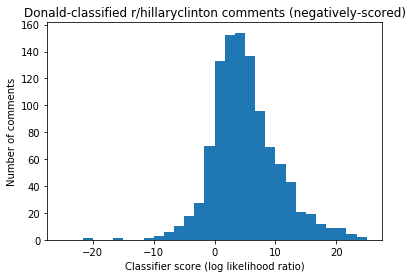

In [171]:
fig, ax=plt.subplots()
ax.set(title = "Donald-classified r/hillaryclinton comments (negatively-scored)", xlabel = "Classifier score (log likelihood ratio)", ylabel = "Number of comments")
plt.hist(classified_hillary_n, bins=30, range=[-25,25])
plt.show()

the distribution definitely looks different from the hillary distributions in the other file.. way more skewed to the right. i wonder why

In [172]:
print(classified_hillary_p.mean())
print(classified_hillary_n.mean())

4.510937002190476
5.655862600319796


In [173]:
#"control" subreddit - ask reddit
classified_askreddit = classify("askreddit")
classified_askreddit_p = classified_askreddit[0]
classified_askreddit_n = classified_askreddit[1]

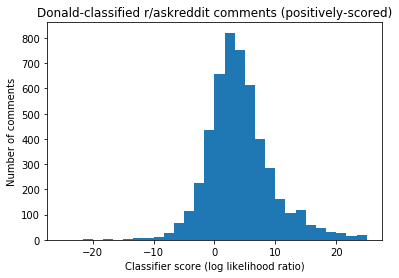

In [174]:
fig, ax=plt.subplots()
ax.set(title = "Donald-classified r/askreddit comments (positively-scored)", xlabel = "Classifier score (log likelihood ratio)", ylabel = "Number of comments")
plt.hist(classified_askreddit_p, bins=30, range=[-25,25])
plt.show()

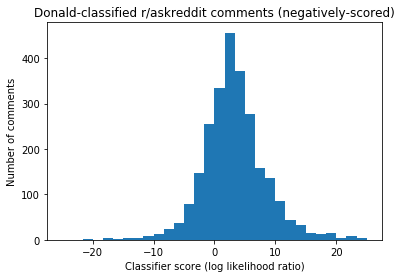

In [175]:
fig, ax=plt.subplots()
ax.set(title = "Donald-classified r/askreddit comments (negatively-scored)", xlabel = "Classifier score (log likelihood ratio)", ylabel = "Number of comments")
plt.hist(classified_askreddit_n, bins=30, range=[-25,25])
plt.show()

In [176]:
print(classified_askreddit_p.mean())
print(classified_askreddit_n.mean())

4.6981029019621205
3.441712761169465


## Exploring topics of comments with outlying classification scores

There were quite a few comments from other subreddits that were rated above 20 or below -20 by a classifier. I was curious about why these comments got such outlying scores, but there were too many to go through by hand. Perfect use case for topic models, though (although the comments are a bit short for topic modelling; 20 or more words). Unfortunately as you will see, the modeling does not elucidate much.

In [177]:
def composition_matrix(sub, valence):
    #sub is subreddit, valence is "pos" or "neg"
    #Return a matrix containing the topic composition of each comment in [sub], [valence]. Shape:(num comments, 20) 
    with open(sub + "_"+ valence + "_commscomp.txt", "r") as inf:
        all_props = inf.readlines()
        doc_topics = np.zeros((len(all_props), 20))
        for i, idx in enumerate(all_props[1:]):
            row = idx.split("\t")[2:]
            doc_topics[i,:] = row
    return doc_topics

In [178]:
hillary_pos_comp = composition_matrix("hillaryclinton", "pos")
hillary_neg_comp = composition_matrix("hillaryclinton", "neg")
h_pos_ln20_indeces = [i for (i,x) in classified_hillary[3]]
h_neg_g20_indeces = [i for (i,x) in classified_hillary[4]]

In [179]:
h_neg_g20_comp = [] #positively scored hillary comments rated greater than 20 by the classifier
for i, x in enumerate (hillary_neg_comp):
    if i in h_neg_g20_indeces:
        h_neg_g20_comp.append(x)
h_neg_g20_comp = np.array(h_neg_g20_comp)

h_pos_ln20_comp = [] #negatively scored hillary comments rated less than -20 by the classifier
for i, x in enumerate (hillary_pos_comp):
    if i in h_pos_ln20_indeces:
        h_pos_ln20_comp.append(x)
h_pos_ln20_comp = np.array(h_pos_ln20_comp)

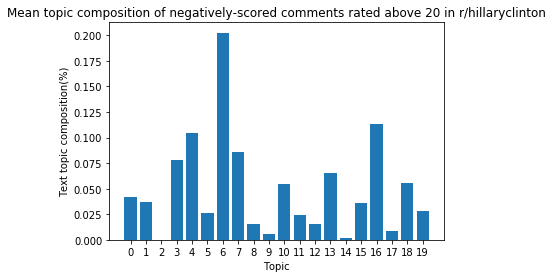

In [180]:
fig, ax=plt.subplots()
ax.bar(np.arange(20), np.mean(h_neg_g20_comp, axis=0))
plt.xticks(np.arange(20), np.arange(20))
ax.set(title = "Mean topic composition of negatively-scored comments rated above 20 in r/hillaryclinton", xlabel = "Topic", \
       ylabel = "Text topic composition(%)")
plt.show()

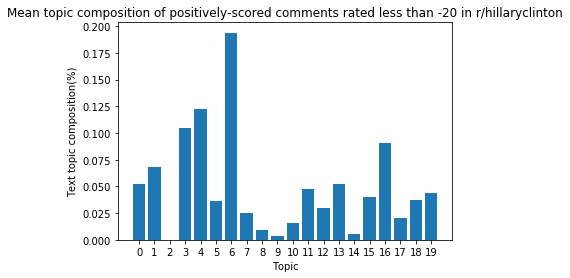

In [181]:
fig, ax=plt.subplots()
ax.bar(np.arange(20), np.mean(h_pos_ln20_comp, axis=0))
plt.xticks(np.arange(20), np.arange(20))
ax.set(title = "Mean topic composition of positively-scored comments rated less than -20 in r/hillaryclinton", xlabel = "Topic", \
       ylabel = "Text topic composition(%)")
plt.show()

Not much difference in topic distribution between positively-rated r/hillary comments rated less than -20 and negatively-rated r/hillary comments rated greater than 20. The changes are pretty small.